# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

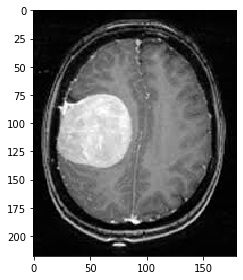

In [1]:
from skimage.io import imread,imshow, imsave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

im = imread('mri_brain.jpg')
imshow(im)

# First solution 

I'm going to present a solution that answers the problem step by step, adding one more step each time I meet a new problem. 

### Results 
First, here is the result : 

| Original image  | Overlay segmentation and original image || Tumour         |
|:-----------------------------:|:-----------------------------:| |:-----------------------------:|
| <img src="mri_brain.jpg"> | <img src="im_result_1.png"> | | <img src="mask_images_2.png"> |


We can see that the tumour is well segmented. 
* The estimated area of the tumour is 45.78 cm². 

### Hypothesis 

First, let's make some hypothesis : 

* The tumour is very bright compared to the rest of the image. 
* There is only one tumour on the image.
* The tumor is not a little object, you can clearly see it. 

# Explanation : 

The tumour is very bright compared to the rest of the image but based on the histogram if we apply an Otsu Threshold it will give a threshhold that won't be able to separate the tumour from the backround. 

* 1) To solve this, we will apply a gamma correction so that the high levels will be more constrasted and as the tumour is very bright compared to the image, it will comes out more than the rest of the image

 Let's see here the histogram of the images : 

| Original image                  | Gamma correction image         |
|:-----------------------------:|:-----------------------------:|
| <img src="original_hist.png"> | <img src="gamma_hist.png"> |

We can see that the gamma correction allows the high levels to be more contrasted.

* 2) Once we have done that, we can apply a Otsu Threshhold to the image to find the best threshold. Otsu will find a threshold that will separate the image into a backgroung and a foreground which are as much different as possible. Everything before the threshold will be considered as the backround (not useful) and everything after the threshold as the foreground. We will then only work in the foreground image in which the tumour is included.

Here is the result of that : 

| Mask                   | Mask * Original Image         |
|:-----------------------------:|:-----------------------------:|
| <img src="mask_original.png"> | <img src="mask_images.png"> |

We can see that we almost segmented the tumour but there are some pixels around the tumour that are not relevant. We need to remove them. Furthermore we can see a little hole in the tumour and we need to fill it because it was done during the thresholding.

* 3) Let's apply an opening followed by a closing, the opening will allow to remove the pixels around the tumour and the closing will allow to fill in the little holes in the tumour. 

Let's see the result of that : 

| Mask + closing(opening)                   | Mask + closing(opening) * Original Image         |
|:-----------------------------:|:-----------------------------:|
| <img src="mask_original_2.png"> | <img src="mask_images_2.png"> |


It seems to be working fine for this image. Let's now get the area of the tumour. 

* 4) Now we need to get the area of the tumour. As we know the resolution of the image, we only have to count the number of pixel that form the tumour and mulltiply this number by the square of the resolution. 

--> Output = 45.78 cm².

So the input parameters are : 

* The image
* The resuolution
* A gamma value
* A disk value for the opening and closing

The ouput is : 

* The segmented tumour
* The estimated area of the tumour (45.78 cm²)

# Issue - Let's try this method with others images to see the possible improvements of this code ! 

I will now use others images, I don't know their resolution so we will **focus on the segmentation part of the project**. We will apply the first  3 methods described above. We will change the inputs parameters to fit the new images. 
The issue with this method is that it will **not work very well on images that have others bright area than the tumour**, like this one : 

| Other tumour image                  | Mask         |
|:-----------------------------:|:-----------------------------:|
| <img src="cT_test.jpg" width="250px" > | <img src="cT_img.png" width="500px"> |


So we can see that the tumour is well represented in the mask but we also have the contour of the brain incuded of the mask because it is bright enough.

# Second solution - More general

* 4) In order to separate the tumour from the contour of the brain we will apply a label transformation, so we can get the differents objects on the image. 

| Label image               
|:-----------------------------:
| <img src="label_image.png" width="500px" >

So we can see that we have about 10 objetcs. Now in order to isolate the tumour we need to be able to remove all the objects except the tumour.

To do that, a intuitive approach would be to think that the tumour is the biggest object on the image (except backround) and therefore take the object that has the highest number of pixels.

* 5) Let's take the label that has the most repetition in the image.


| Biggest object on the image                   | Overlay mask * image         |
|:-----------------------------:|:-----------------------------:|
| <img src="label_object_remove.png" width="500px" > | <img src="label_object_remove_overlay.png" width="500px"> |


### Issue ! If we change a bit the gamma value, here is the result : 


| Label image issue               
|:-----------------------------:
| <img src="label_image_issue.png" width="500px" >

We can see here that if an object has more pixels than the tumour, it will be taken as the tumour by the program. We need to find a solution to avoid this situation. 


## Region descriptors : we need a other way to choose which object we want to keep !

* 6) Regions descritors : what we want here to find a way to choose the right object on the image which is the tumour. We can see that **the tumour is dense and located at only one place**. The others objects might be big but they are less dense than the tumour and we are going to use that to isolate the tumour. </br> For that we will use region descritors. We will divide the image into blocks and every pixel of each block will have a value that is the median of the pixel corresponding to the block on the image. But we will take **blocks that are big enough** so that **object that are thick but bright will have a lower value** that big and dense object. It is a bit like doing a density detector. 

Here is the result : 


| Original image                   | image descriptor         |
|:-----------------------------:|:-----------------------------:|
| <img src="cT_test.png" width="250px" > | <img src="im_descr_show.png" width="500px"> |

We can see that in the image descriptor, the brightest block well correspond to the tumour location. 

We can then isolate this region : 

| Original image                   | image descriptor isolated region        |
|:-----------------------------:|:-----------------------------:|
| <img src="cT_test.png" width="250px" > | <img src="im_descr_max_show.png" width="500px"> |



* 7) Once we have isolated this region, for each label we can simply count the number of pixels that in commun between the label and this isolated region. We will then take the label with the most pixels in commun with this region. It is why it is important to take a small number of blocks because you take a high number of blocks, it is possible that a thick and bright object will be considered as the tumour location. 

Result : 

| Label image                   | Isolated label, the tumour       |
|:-----------------------------:|:-----------------------------:|
| <img src="im_label_final.png" width="500px" > | <img src="im_label_final_isolate.png" width="500px"> |



| Original image                   | Mask * Image       |
|:-----------------------------:|:-----------------------------:|
| <img src="cT_test.png" width="250px" > | <img src="im_cT_final_.jpg" width="250px"> |



# This method also works on others image (change the gamma value manually !) : 



| New tumour image                   | Mask * image       |
|:-----------------------------:|:-----------------------------:|
| <img src="tumour_child.jpg" width="500px" > | <img src="tumour_child_segmented_.jpg" width="500px"> |



| New tumour image                   | Mask * image       |
|:-----------------------------:|:-----------------------------:|
| <img src="test_info.jpg" width="250px" > | <img src="TEEEEST.jpg" width="250px"> |


| New tumour image                   | Mask * image       |
|:-----------------------------:|:-----------------------------:|
| <img src="brain_tumour_test_4.jpg" width="250px" > | <img src="im_test_4_result_.jpg" width="250px"> |




### Input 

The inputs parameters are the same, you might just need to change the gamma value (and the disk size for more precision). 




See "First solution" below to see the code of the first solution and see "second solution" below to see the code of the second solution.

**Thank you for reading !**

# First solution

Number of pixels in the tumour 3462
Area of the tumour :  45.78 cm²


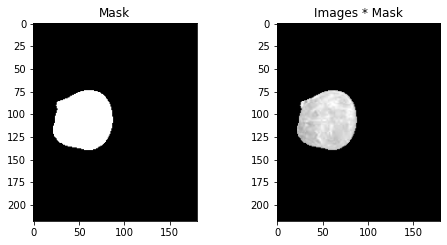

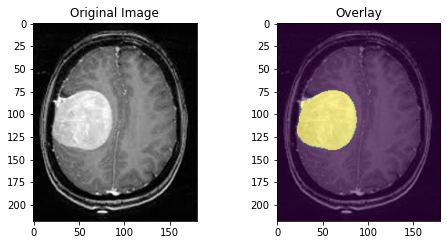

In [5]:
resolution = 0.115
im = (imread('mri_brain.jpg',as_gray=True)*255).astype("uint8")
gamma = 2.0
disk_size = 5
im_gamma = lut_gamma(im,gamma)

T = threshold_otsu(im_gamma)

mask = im_gamma>T
mask = closing(opening(mask, disk(disk_size)), disk(disk_size))



plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(mask, cmap= plt.cm.gray)
plt.title('Mask')
plt.subplot(2,2,2)
plt.imshow(im*mask, cmap= plt.cm.gray)
plt.title('Images * Mask')



plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(im, cmap= plt.cm.gray)
plt.title('Original Image')
plt.subplot(2,2,2)
plt.imshow(im, cmap= plt.cm.gray)
plt.imshow(mask, alpha = 0.5)
plt.title('Overlay')


estimate_area(mask,resolution )

# Second solution - more general

[6025.    0.    0.    0.    0.    0. 8368.  979.    0.    0.    0.]


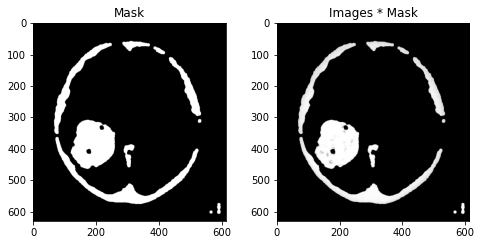

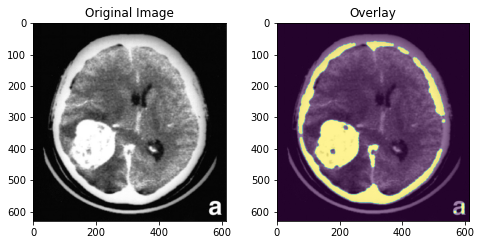

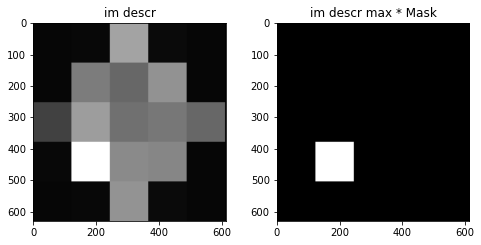

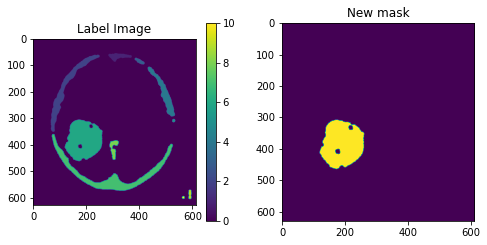

<Figure size 432x288 with 0 Axes>

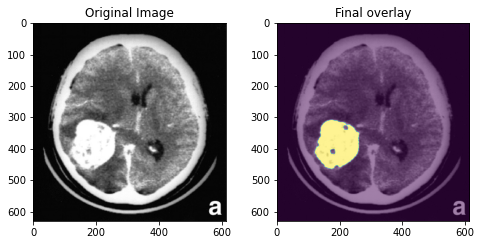

In [20]:
im = (imread('cT_Test.png',as_gray=True)*255).astype("uint8")
gamma =5.0
disk_size = 5
region_descriptors_shape = 5



im_gamma = lut_gamma(im,gamma)
T = threshold_otsu(im_gamma)

mask = im_gamma>T
mask = closing(opening(mask, disk(disk_size)), disk(disk_size))


plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(mask, cmap= plt.cm.gray)
plt.title('Mask')
plt.subplot(2,2,2)
plt.imshow(im*mask, cmap= plt.cm.gray)
plt.title('Images * Mask')


plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(im, cmap= plt.cm.gray)
plt.title('Original Image')
plt.subplot(2,2,2)
plt.imshow(im, cmap= plt.cm.gray)
plt.imshow(mask, alpha = 0.5)
plt.title('Overlay')




# LABEL - Cut into labels and find the label matching the tumour
im_label = label(mask)

#Compute image descriptor
im_descr = sliding_window(im.astype('float'),(im.shape[0]//region_descriptors_shape,im.shape[1]//region_descriptors_shape))
max_ = np.max(im_descr.flatten())
im_descr_max = im_descr.copy()
im_descr_max[im_descr < max_] = 0 

max_label= np.max(im_label.flatten())+1



#Get the commun pixel of each object with the max of im_descr

commun_pixel = np.zeros(max_label)
for z in range(max_label):
    for y in range(im_descr_max.shape[0]):
        for x in range(im_descr_max.shape[1]):
            if (im_descr_max[y,x] > 0 ):
                if (im_label[y,x] == z):
                    commun_pixel[z] += 1
                    
                    
                    
                    
print(commun_pixel)

commun_pixel[0] = 0 #can't be the backround
x = (np.where(commun_pixel== np.max(commun_pixel)))

new_mask = (im_label == x)



plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(im_descr, cmap= plt.cm.gray)
plt.title('im descr')
plt.subplot(2,2,2)
plt.imshow(im_descr_max, cmap= plt.cm.gray)
plt.title('im descr max * Mask')


plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(im_label)
plt.colorbar()
plt.title('Label Image')
plt.subplot(2,2,2)
plt.imshow(new_mask)                    
plt.title('New mask')
plt.figure()


plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(im, cmap= plt.cm.gray)
plt.title('Original Image')
plt.subplot(2,2,2)
plt.imshow(im, cmap= plt.cm.gray)
plt.imshow(new_mask, alpha = 0.5)
plt.title('Final overlay')

In [3]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.morphology import opening, closing, disk
from  skimage.transform import resize
from skimage.measure import label

def texture_descriptor(N):
    e = np.median(N)
    return e

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

def lut_gamma(im, gamma):
    lut = (np.power(np.arange(0,256), gamma) * np.power(255, 1-gamma)).astype('uint8')  
    return lut[im]

def estimate_area(im, resolution):
    count =0
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y,x] == True):
                count+=1
    print('Number of pixels in the tumour', count)
    print('Area of the tumour : ', np.round(count * resolution * resolution, 2), 'cm²')

def plot_hist(im, name):
    h, bins = np.histogram(im.flatten(), bins = range(257), density = True)
    plt.figure(figsize=(10,5))
    plt.hist(im.flatten(), bins=range(256),density=True)
    plt.savefig(name)